In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft

In [3]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.on_after_forward = swyft.to_numpy32
        
    def forward(self, trace):
        z = trace.sample('z', np.random.rand, 3)
        mu = trace.sample("mu", lambda z: np.array([z[0], z[0]+z[1], z[0]+z[1]+z[2]]), z)
        x = trace.sample('x', lambda mu: mu + np.random.randn(3)*0.02, mu)

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__(lr=1e-3)
        marginals = ((0, 1, 2),)
        self.classifier = swyft.RatioEstimatorMLPnd(3, marginals, hidden_features = 256, dropout = 0.1)

    def forward(self, A, B):
        x = A['x']
        z = B['z']
        ratios_z = self.classifier(x, z)
        return dict(z = ratios_z)

In [5]:
simulator = Simulator()
samples = simulator(10000)

100%|██████████| 10000/10000 [00:00<00:00, 29527.45it/s]


In [6]:
dl_train = samples[:8000].get_dataloader(batch_size = 128, shuffle = True)
dl_valid = samples[8000:9000].get_dataloader(batch_size = 128)
dl_test = samples[9000:].get_dataloader(batch_size = 128)

In [7]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 100, **swyft.tensorboard_config(name = '05-minimal-example-m-dim', version=None))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
network = Network()

In [9]:
trainer.fit(network, dl_train, dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | classifier | RatioEstimatorMLPnd | 267 K 
---------------------------------------------------
267 K     Trainable params
0         Non-trainable params
267 K     Total params
1.069     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  89%|████████▊ | 63/71 [00:00<00:00, 95.28it/s, loss=-1.32, v_num=1]   
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▊ | 63/71 [00:00<00:00, 92.31it/s, loss=-1.3, v_num=1, val_loss=-.949]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▊ | 63/71 [00:00<00:00, 95.43it/s, loss=-1.34, v_num=1, val_loss=-.848] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▊ | 63/71 [00:00<00:00, 95.12it/s, loss=-1.36, v_num=1, val_loss=1.200] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▊ | 63/71 [00:00<00:00, 96.77it/s, loss=-1.36, v_num=1, val_loss=-1.11] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▊ | 63/71 [00:00<00:00, 91.78it/s, loss=-1.35, v_num=1, val_loss=-1.30] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▊ | 63/71 [00:00<00:00, 97.42it/s, loss=-1.35, v_num=1, val_loss=-1.33]
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████▊ | 63/71 [00:00<00:00, 91.84it/s, loss=-1.34, v_num=1, val_loss=-1.33] 
Validating: 0it [00:00, ?it/s]
Epoch 8

In [10]:
trainer.test(network, dl_test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': -0.6877778768539429, 'hp/KL-div': -2.5519611835479736}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 8/8 [00:00<00:00, 198.25it/s]


[{'hp/JS-div': -0.6877778768539429, 'hp/KL-div': -2.5519611835479736}]

In [11]:
x0 = [0.3, 0.5, 0.7]
prior_samples = simulator(1000000, targets = ['z'])

100%|██████████| 1000000/1000000 [00:11<00:00, 85229.06it/s]


In [12]:
predictions = trainer.infer(network, {'x': torch.tensor(x0)}, prior_samples.get_dataloader(batch_size = 1024))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting:   8%|▊         | 83/977 [00:00<00:04, 199.08it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting: 100%|██████████| 977/977 [00:05<00:00, 176.87it/s]


In [13]:
post_samples = predictions.sample(100000)
z = post_samples['z'][:,0,:].numpy()

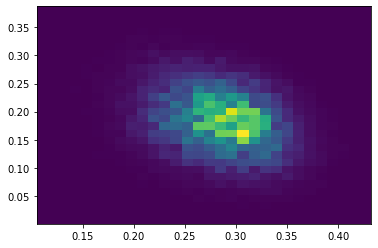

In [14]:
plt.hist2d(z[:,0], z[:,1], density = True, bins = 30);

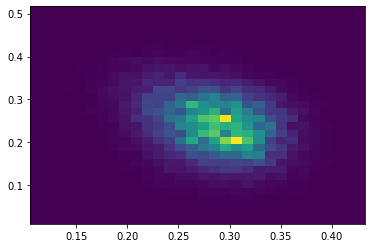

In [15]:
plt.hist2d(z[:,0], z[:,2], density = True, bins = 30);

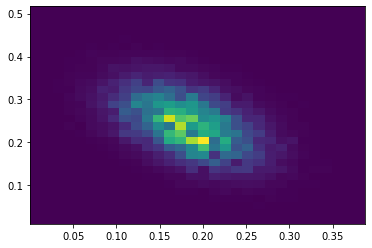

In [16]:
plt.hist2d(z[:,1], z[:,2], density = True, bins = 30);